In [1]:
%matplotlib inline
import time
import os
import numpy as np
import pandas as pd
import gzip
import json

import matplotlib.pyplot as plt
from matplottery import Hist1D

Download traffic arrest data for Montgomery County, Maryland (~1GB uncompressed, 150MB gzipped)

In [2]:
! test -e data.json.gz || curl "https://data.montgomerycountymd.gov/api/views/4mse-ku6q/rows.json?accessType=DOWNLOAD" | gzip -c > data.json.gz

Bunch of conversion from trial and error lumped into a single function

In [3]:
def get_df():
    # OK, it's a monster...
    
    # Return data frame if we've already saved it into a (compressed) pickle
    if os.path.exists("data.pkl.gz"):
        return pd.read_pickle("data.pkl.gz")
    
    # Otherwise do the fun data munging
    # We first open as a vanilla json to get column names
    js = json.load(gzip.open("data.json.gz"))
    columns = [x for x in js["meta"]["view"]["columns"]]
    colnames = [c[("fieldName" if c["id"]>=0 else "name")] for c in columns]
    print("opened")
    
    # Then onto pandas
    df = pd.DataFrame(js["data"],columns=colnames)
    print("made df")
    
    # Ignore some columns
    to_ignore = set([
        "seq_id","sid","id","position","created_at","created_meta",
        "updated_at","updated_meta","meta","location","latitude","longitude","geolocation"
        ] + [c for c in colnames if "@" in c])
    df = df.drop(to_ignore,axis=1)

    # Make sane format for datetime
    df["time"] = pd.to_datetime(df["date_of_stop"].str.split("T",n=1,expand=True)[0]+"T"+df["time_of_stop"])
    df = df.drop(["driver_city","agency","date_of_stop","time_of_stop","article","charge"],axis=1)

    # Booleanize the stupid "Yes"/"No" strings
    ks = ["belts","accident","personal_injury","property_damage","fatal","commercial_vehicle","hazmat","commercial_license","alcohol","work_zone","contributed_to_accident"]
    df[ks] = df[ks].eq("Yes")
    print("did booleanization")

    # Misc conversions
    df["arrest_type"] = df["arrest_type"].str.split(" ",n=1,expand=True)[0]
    df["year"] = df["year"].fillna(-1).astype(int)
    df["subagency"] = pd.to_numeric(df["subagency"].str[0], errors="coerce").fillna(8).astype(int)
    df["violation_type"] = df["violation_type"].str[0]
    df["involved_speed"] = (df["description"].str.contains("EXCEEDING",na=False).fillna(False) | df["description"].str.contains("SPEED",na=False).fillna(False))
    df["involved_handheld"] = df["description"].str.contains("HANDHELD",na=False).fillna(False)
    df["involved_alcohol"] = df["description"].str.contains("ALCOHOL",na=False).fillna(False)

    # Make a bunch of string things into category types to save space/cpu
    ks = ["color","violation_type","race","gender","arrest_type","description","vehicle_type"]
    df[ks] = df[ks].astype("category")
    print("made categories")

    # Get outta here
    df = df.drop(["description","dl_state","driver_state","vehicle_type","make","model","state"],axis=1)
    clean_years = ((df["year"]>1950) & (df["year"]<=2019))
    df = df[clean_years]
    
    # gz compresses in 40s, uncompresses in 0.4s
    # bz2 in 5s, 2s
    t0 = time.time()
    print("pickling now")
    df.to_pickle("data.pkl.gz")
    print("done pickling in {:.1f}".format(time.time()-t0))
    return df


Get dataframe (~10MB gzipped). Rename some things and make convenience columns for the arrest hour (finer granularity by using minutes) and the year (finer granularity using month and day) for binning purposes later.

In [4]:
dfc = get_df()

In [5]:
dfc = dfc.set_index("time",drop=False)
dfc = dfc.rename(columns={"belts":"involved_belts","year":"vehicle_year"})
dfc["hour"] = dfc.index.hour + dfc.index.minute/60.
dfc["year"] = dfc.index.year + dfc.index.month/12. + dfc.index.day/365.

In [6]:
dfc.head()

,subagency,accident,involved_belts,personal_injury,property_damage,fatal,commercial_license,hazmat,commercial_vehicle,alcohol,...,contributed_to_accident,race,gender,arrest_type,time,involved_speed,involved_handheld,involved_alcohol,hour,year
time,,,,,,,,,,,,,,,,,,,,,
2019-05-31 22:48:00,1,False,False,False,False,False,False,False,False,False,...,False,WHITE,M,A,2019-05-31 22:48:00,False,False,False,22.800000,2019.501598
2019-05-31 22:40:00,4,False,False,False,False,False,False,False,False,False,...,False,BLACK,M,A,2019-05-31 22:40:00,False,False,False,22.666667,2019.501598
2019-05-31 22:38:00,4,False,False,False,False,False,False,False,False,False,...,False,BLACK,F,A,2019-05-31 22:38:00,False,False,False,22.633333,2019.501598
2019-05-31 22:38:00,4,False,False,False,False,False,False,False,False,False,...,False,BLACK,F,A,2019-05-31 22:38:00,False,False,False,22.633333,2019.501598
2019-05-31 22:37:00,5,False,False,False,False,False,False,False,False,False,...,False,BLACK,M,A,2019-05-31 22:37:00,False,False,False,22.616667,2019.501598


In [7]:
dfc.describe(include="all")

,subagency,accident,involved_belts,personal_injury,property_damage,fatal,commercial_license,hazmat,commercial_vehicle,alcohol,...,contributed_to_accident,race,gender,arrest_type,time,involved_speed,involved_handheld,involved_alcohol,hour,year
count,1.516393e+06,1516393,1516393,1516393,1516393,1516393,1516393,1516393,1516393,1516393,...,1516393,1516393,1516393,1516393,1516393,1516393,1516393,1516393,1.516393e+06,1.516393e+06
unique,NaN,2,2,2,2,2,2,2,2,2,...,1,6,3,19,730238,2,2,2,NaN,NaN
top,NaN,False,False,False,False,False,False,False,False,False,...,False,WHITE,M,A,2017-04-27 14:36:00,False,False,False,NaN,NaN
freq,NaN,1487325,1467911,1499145,1487325,1516055,1472310,1516261,1509776,1514082,...,1516393,537983,1015505,1256883,59,1273718,1478258,1462864,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2012-01-01 00:43:00,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2019-05-31 22:48:00,NaN,NaN,NaN,NaN,NaN
mean,3.623620e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.344270e+01,2.015942e+03
std,1.713901e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.237019e+00,2.051146e+00
min,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,2.012086e+03
25%,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.366667e+00,2.014288e+03


In [8]:
def style_ax(ax):
    ax.xaxis.set_ticks([0.,3.,6.,9.,12.,15.,18.,21.,24])
    ax.xaxis.set_ticklabels(("12am","3am","6am","9am","12pm","3pm","6pm","9pm","12am"))

Plot arrest time distribution (within a day) split by gender (and also normalized on the right)

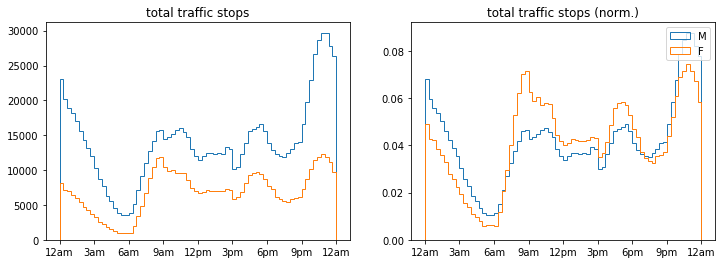

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
bins = np.linspace(0,24,72+1)
gb = dfc.groupby("gender")
for k in gb.groups.keys():
    if k in ["U"]: continue
    df = gb.get_group(k)
    ax1.hist(df.hour.values,bins=bins,label=k,histtype="step",stacked=False)
    ax2.hist(df.hour.values,bins=bins,label=k,histtype="step",stacked=False,density=True)
map(style_ax,[ax1,ax2])
ax1.set_title("total traffic stops")
ax2.set_title("total traffic stops"+" (norm.)")
ax2.legend()


Plot same thing as above, but for events involving belts, handheld devices, speeding, or alcohol.

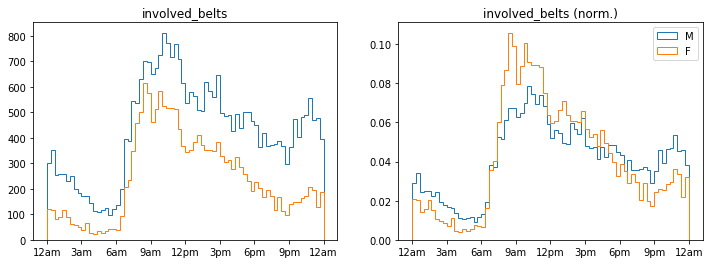

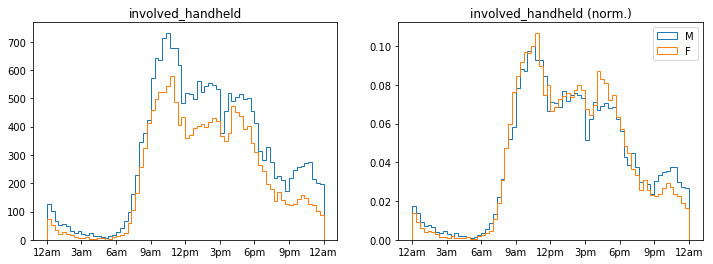

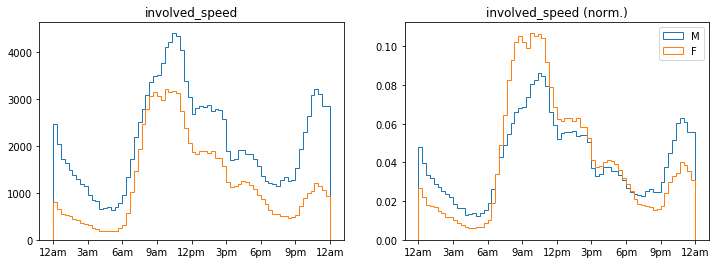

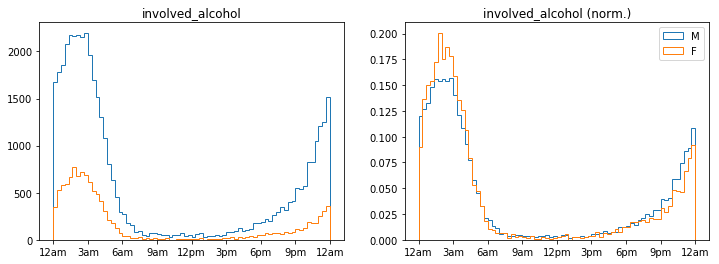

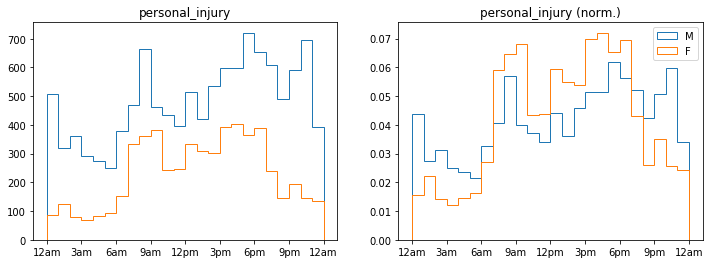

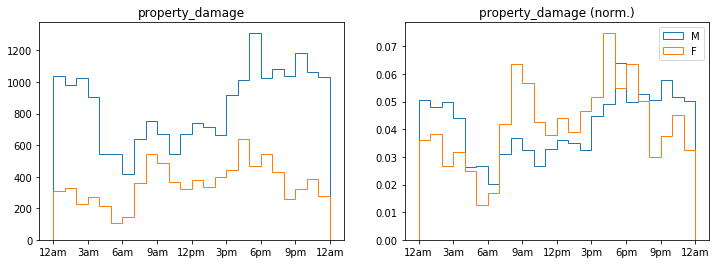

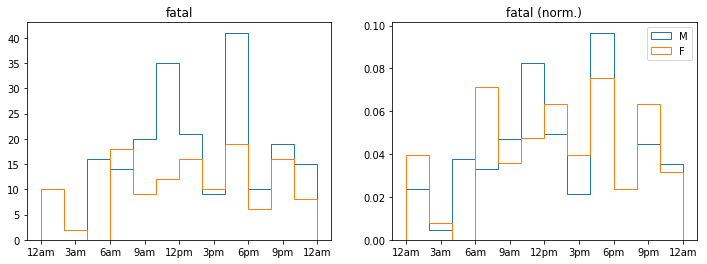

In [10]:
for which,bins in [
    ["involved_belts",np.linspace(0,24,72+1)],
    ["involved_handheld",np.linspace(0,24,72+1)],
    ["involved_speed",np.linspace(0,24,72+1)],
    ["involved_alcohol",np.linspace(0,24,72+1)],
    ["personal_injury",np.linspace(0,24,24+1)],
    ["property_damage",np.linspace(0,24,24+1)],
    ["fatal",np.linspace(0,24,12+1)],
]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
    gb = dfc.groupby("gender")
    for k in gb.groups.keys():
        if k in ["U"]: continue
        df = gb.get_group(k)
        df = df[df[which]]
        ax1.hist(df.hour.values,bins=bins,label=k,histtype="step",stacked=False)
        ax2.hist(df.hour.values,bins=bins,label=k,histtype="step",stacked=False,density=True)
    map(style_ax,[ax1,ax2])
    ax1.set_title(which)
    ax2.set_title(which+" (norm.)")
    ax2.legend()

Split by race now

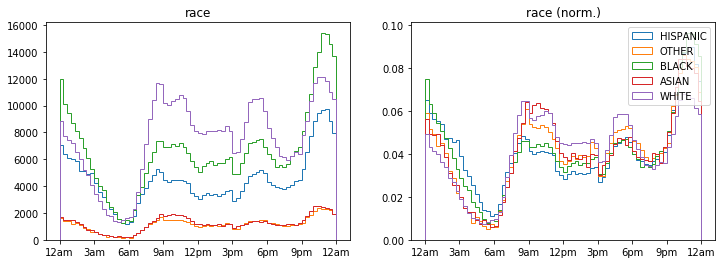

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
bins = np.linspace(0,24,72+1)
gb = dfc.groupby("race")
for k in gb.groups.keys():
    if k in ["NATIVE AMERICAN"]: continue # low stats, sorry D:
    df = gb.get_group(k)
    ax1.hist(df.hour.values,bins=bins,label=k,histtype="step",stacked=False)
    ax2.hist(df.hour.values,bins=bins,label=k,histtype="step",stacked=False,density=True)
map(style_ax,[ax1,ax2])
ax1.set_title("race")
ax2.set_title("race"+" (norm.)")
ax2.legend()

Split by race again, but plot as a function of year to see if there are trends

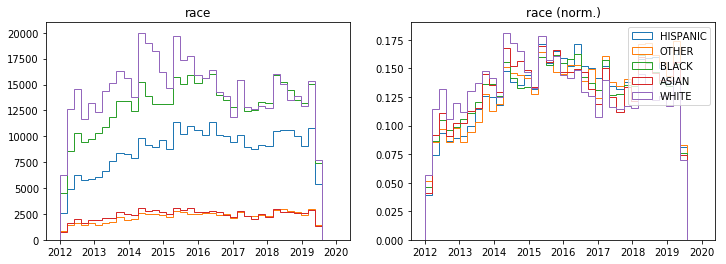

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
bins = np.linspace(2012,2020,40)
# bins = np.linspace(2012,2020,9)
gb = dfc.groupby("race")
hists = {}
for k in gb.groups.keys():
    if k in ["NATIVE AMERICAN"]: continue # low stats, sorry D:
    df = gb.get_group(k)
    h = Hist1D(df.year.values,bins=bins)
    hists[k] = h
    ax1.hist(df.year.values,bins=bins,label=k,histtype="step",stacked=False)
    ax2.hist(df.year.values,bins=bins,label=k,histtype="step",stacked=False,density=True)
hists["TOTAL"] = Hist1D(dfc.year.values,bins=bins)
for k in hists:
    hists[k] /= hists[k].get_integral()
# map(style_ax,[ax1,ax2])
ax1.set_title("race")
ax2.set_title("race"+" (norm.)")
ax2.legend()

Well, the trend might just be due to population distribution changes, so lets see how consistent that hypothesis is with a very non-rigorous comparison using the ACS data. I took a lot of liberty converting the race categories from that data into what's shown below. The raw data looks like
```
  # 2017
Montgomery County, Maryland
Estimate      Margin of Error
Total:        1,039,198       *****
Not Hispanic or Latino:       841,956 *****
White alone   467,734 +/-667
Black or African American alone       182,541 +/-1,312
American Indian and Alaska Native alone       1,394   +/-232
Asian alone   152,515 +/-990
Native Hawaiian and Other Pacific Islander alone      458     +/-133
Some other race alone 4,969   +/-785
Two or more races:    32,345  +/-1,474
Two races including Some other race   2,177   +/-547
Two races excluding Some other race, and three or more races  30,168  +/-1,525
Hispanic or Latino:   197,242 *****
```
and my parsing methodology mapped
```
        Total -> total
        White alone -> white
        Black or African -> black
        Asian -> asian
        Hispanic or Latino -> hispanic
        Some other race alone -> other
        Two or more races -> other
        Native Hawaiian -> other
        American Indian -> other
```

Plot the percent growth wrt 2009 for each race

,asian,black,hispanic,other,total,white
year,,,,,,
2009,124195,150771,142509,24080,946172,504617
2010,129852,156096,151842,26686,947230,482754
2011,131693,160575,158814,28500,959738,480156
2012,135573,162939,166124,30480,974824,479708
2013,138468,166210,173135,32994,989474,478667
2014,142658,170308,180397,34998,1005087,476726
2015,147053,174395,186225,36079,1017859,474107
2016,148778,177896,190550,37671,1026371,471476
2017,152515,182541,197242,39166,1039198,467734


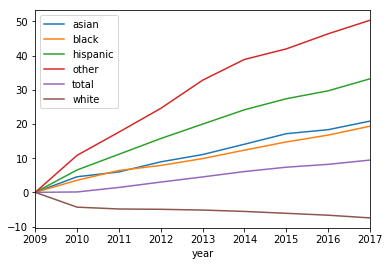

In [13]:
# https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_17_1YR_B02001&prodType=table
df_census = pd.read_json("census.json").set_index("year")
(df_census.pct_change()*100).cumsum().fillna(0.).plot()
df_census

The arrest dataset only goes back to 2012, so drop the first few years of census data

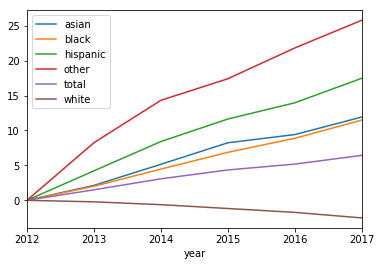

In [14]:
df_census = df_census.drop(index=[2009,2010,2011],errors="ignore")

(df_census.pct_change()*100).cumsum().fillna(0.).plot()

For each race, plot the time-binned arrest counts. Fit a red line to it. Then look at the yearly growth predicted by the census data and plot this as a line in blue. In most cases we see rough agreement in the trend. I mean, at least it's a "win" that the slopes aren't opposite...

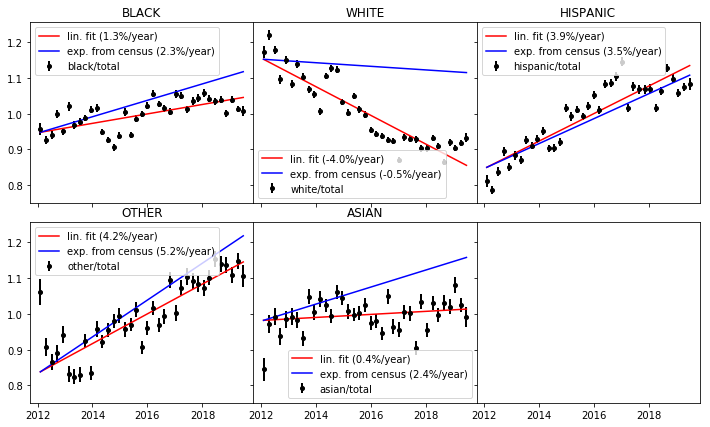

In [15]:
# doplot(hs,daily=False,extra=dict(xlabel="Arrest year"))
pct_per_year_race = (df_census.pct_change()*100).cumsum().fillna(0.).tail(1).iloc[0]/(df_census.index.max()-df_census.index.min())
fig,axs = plt.subplots(2,3,figsize=(12,7),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0.11,wspace=0.0)
races = ["BLACK","WHITE","HISPANIC","OTHER","ASIAN"]
for ax,numer in zip(axs.flat,races):
    ratio = Hist1D(hists[numer]/hists["TOTAL"],label="{}/total".format(numer.lower()))
    mask = np.isfinite(ratio.counts)
    xfit = ratio.get_bin_centers()[mask]
    lin = np.polyfit(xfit, ratio.counts[mask], 1, w=1./ratio.errors[mask])
    yfit = lin[0]*xfit+lin[1]
    ax.errorbar(xfit,ratio.counts[mask],yerr=ratio.errors[mask],color="k",marker="o",markersize=4,linewidth=2.,linestyle="",label="{}/total".format(numer.lower()))
    ax.plot(xfit,yfit,color="r",label="lin. fit ({:.1f}%/year)".format(lin[0]*100.))
    ax.plot([xfit[0],xfit[-1]],[yfit[0],yfit[0]+0.01*(xfit[-1]-xfit[0])*pct_per_year_race[numer.lower()]],color="b",label="exp. from census ({:.1f}%/year)".format(pct_per_year_race[numer.lower()]))
    ax.set_title(numer)
    ax.legend()
# print ratio


Get the average vehicle year as a function of the traffic stop year for each race (to see how old the cars are).

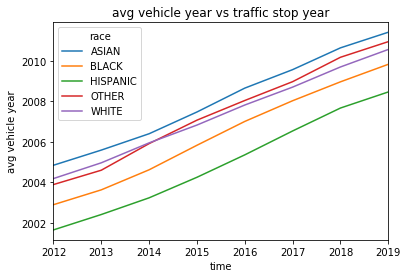

In [16]:
df = (dfc
      .groupby([dfc.index.year,"race"])["vehicle_year"]
      .agg("mean")
      .unstack("race")
      .drop(["NATIVE AMERICAN"],axis=1)
     )
ax = df.plot()
ax.set_ylabel("avg vehicle year")
ax.set_title("avg vehicle year vs traffic stop year");

Same as above, but viewed a different way. The distributions themselves aren't particularly enlightening since you have to account for the fact that a car can' be newer than the arrest date.

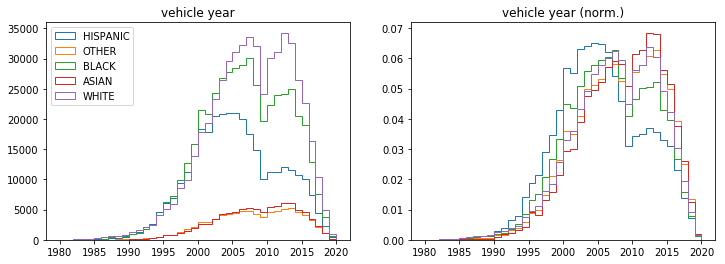

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
bins = np.linspace(1980,2020,41)
gb = dfc.groupby("race")
for k in gb.groups.keys():
    if k in ["NATIVE AMERICAN"]: continue
    df = gb.get_group(k)
    ax1.hist(df.vehicle_year.values,bins=bins,label=k,histtype="step",stacked=False)
    ax2.hist(df.vehicle_year.values,bins=bins,label=k,histtype="step",stacked=False,density=True)
# map(style_ax,[ax1,ax2])
ax1.set_title("vehicle year")
ax2.set_title("vehicle year"+" (norm.)")
ax1.legend(loc="upper left")

Make a smaller set of colors ("Blue, dark" is "blue", "Multicolor" is "other", ...)

In [18]:
dfc["color"] = dfc["color"].str.split(",").str[0].str.lower().map(dict(
    black="black",
    silver="gray",
    white="white",
    green="green",
    red="red",
    gray="gray",
    blue="blue",
)).fillna("other")

print dfc["color"].str.split(",").str[0].value_counts()

gray     451126
black    310880
white    237431
blue     163049
other    155845
red      119053
green     79009
Name: color, dtype: int64


Distribution of arrest time for different vehicle colors, restricting to "white" race, otherwise we're folding in correlations with arrest time per race.

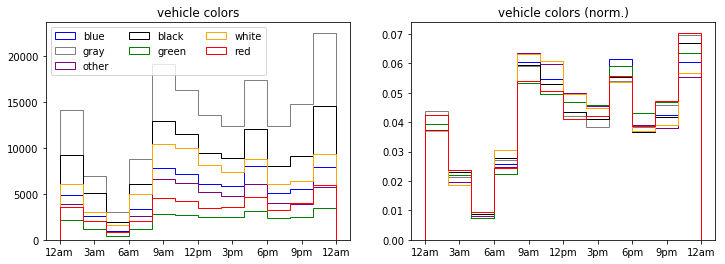

In [19]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
bins = np.linspace(0,24,12+1)
gb = dfc[dfc["race"]=="WHITE"].groupby("color")
for k in gb.groups.keys():
    df = gb.get_group(k)
    col = k.replace("white","orange").replace("other","purple")
    ax1.hist(df.hour.values,bins=bins,label=k,histtype="step",stacked=False,color=col)
    ax2.hist(df.hour.values,bins=bins,label=k,histtype="step",stacked=False,density=True,color=col)
map(style_ax,[ax1,ax2])
ax1.set_title("vehicle colors")
ax2.set_title("vehicle colors"+" (norm.)")
ax1.legend(ncol=3,loc="upper left")